In [ ]:
# install syft if working on colab
!pip install syft

In [ ]:
# unzip DRIVE and STARE datasets
!unzip /content/drive/My\ Drive/Colab\ Notebooks/VesselSegmentation/Source_DRIVE_datasets.zip
!unzip /content/drive/My\ Drive/Colab\ Notebooks/VesselSegmentation/Target_STARE_Dataset.zip

In [1]:
# import
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import syft as sy
import copy
import os

from model import UNet
from generator import DatasetGenerator
from util import *

In [2]:
# initilize directories of the datasets
DRIVE_imagesDir = "/content/Source_DRIVE_datasets/training/images"
DRIVE_masksDir = "/content/Source_DRIVE_datasets/training/1st_manual"

STARE_imagesDir = "/content/Target_STARE_Dataset/stare-images"
STARE_masksDir = "/content/Target_STARE_Dataset/labels-ah"

In [3]:
# initialze arguments and device
args = Arguments()
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# initialize dataset dictionary and DataGen object
data_dirs = {
    "DRIVE": [DRIVE_imagesDir, DRIVE_masksDir],
    "STARE": [STARE_imagesDir, STARE_masksDir]
}

DataGen = DatasetGenerator(data_dirs, args)

In [5]:
# Generate dataset loader for DRIVE and STARE
DriveDatasetLoader = DataGen.generateTrainDataset("DRIVE")
StareDatasetLoader = DataGen.generateTrainDataset("STARE")

[INFO] Generating Training Dataset Loader for DRIVE...
[INFO] Total number of images for DRIVE training dataset: 16
[INFO] Total number of masks for DRIVE training dataset: 16
[INFO] Generating Training Dataset Loader for STARE...
[INFO] Total number of images for STARE training dataset: 16
[INFO] Total number of masks for STARE training dataset: 16


Image Shape:  torch.Size([16, 3, 224, 224]) 
Mask Shape:  torch.Size([16, 3, 224, 224])


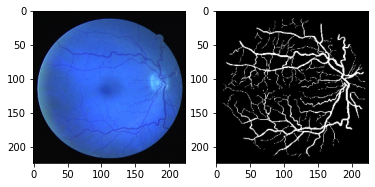

In [6]:
# plot image form the dataset
plot_images(DriveDatasetLoader, 0)

In [7]:
# define train function for DRIVE and STARE datasets
def train_model(trainDatasetLoader, model, optimizer, num_epochs=25):
    # keep track of best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(1, num_epochs + 1):
        # Set model to training mode
        model.train()  

        epoch_samples = 0

        for inputs, labels in trainDatasetLoader:
            # send data to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            loss = calculate_loss(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            epoch_samples += inputs.size(0)

        epoch_loss = loss / epoch_samples

        # deep copy the model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        # print loss
        if epoch % args.log_interval == 0:
            print("[INFO] Loss after {} epochs: {:.4f}".format(epoch,
                                                              epoch_loss.item()))

    print('Best loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [8]:
# initialize models and optimizer
num_class = 3
model = UNet(num_class).to(device)

optimizer = optim.Adam(model.parameters(), lr=args.lr)

In [9]:
# train model on DRIVE dataset
print("Training model on DRIVE dataset...")
model_drive = train_model(DriveDatasetLoader, model, optimizer, num_epochs=args.epochs)

Training model on DRIVE dataset...
[INFO] Loss after 10 epochs: 0.0530
[INFO] Loss after 20 epochs: 0.0524
[INFO] Loss after 30 epochs: 0.0511
[INFO] Loss after 40 epochs: 0.0506
[INFO] Loss after 50 epochs: 0.0495
[INFO] Loss after 60 epochs: 0.0475
[INFO] Loss after 70 epochs: 0.0473
[INFO] Loss after 80 epochs: 0.0473
[INFO] Loss after 90 epochs: 0.0473
[INFO] Loss after 100 epochs: 0.0473
Best loss: 0.047254


In [10]:
# train model on STARE dataset
print("Training model on STARE dataset...")
model_stare = train_model(StareDatasetLoader, model, optimizer, num_epochs=args.epochs)

Training model on STARE dataset...
[INFO] Loss after 10 epochs: 0.0506
[INFO] Loss after 20 epochs: 0.0504
[INFO] Loss after 30 epochs: 0.0502
[INFO] Loss after 40 epochs: 0.0501
[INFO] Loss after 50 epochs: 0.0501
[INFO] Loss after 60 epochs: 0.0500
[INFO] Loss after 70 epochs: 0.0499
[INFO] Loss after 80 epochs: 0.0499
[INFO] Loss after 90 epochs: 0.0498
[INFO] Loss after 100 epochs: 0.0498
Best loss: 0.049824


In [11]:
# generate FL DataLoader and workers
FederatedDatasetLoader, workers = DataGen.generateFederatedDataset()

[INFO] Generating Federated Dataset Loader...
[INFO] Total number of images for FEDERATED training dataset: 32
[INFO] Total number of masks for FEDERATED training dataset: 32


In [12]:
# get the workers
bob, alice, jon = workers # jon -> secure worker

In [13]:
# define train function for FL dataset
def train(args, model, device, train_loader, optimizer, epoch):

	# copy models and send it to workers
    model_bob = model.copy().send(bob)
    model_alice = model.copy().send(alice)

    # initialize optimizers for the models
    opt_bob = optim.Adam(model_bob.parameters(), lr=args.lr)
    opt_alice = optim.Adam(model_alice.parameters(), lr=args.lr)

    getModelOpt = {
    	model_bob.location: (model_bob, opt_bob), 
    	model_alice.location: (model_alice, opt_alice)
    }

    # set model to train
    model_bob.train()
    model_alice.train()

    epoch_samples = 0
    for batch_idx, (_data, _target) in enumerate(train_loader): 
        # send data to location
        (_model, _opt) = getModelOpt[_data.location]
        _data, _target = _data.to(device), _target.to(device)
        
        # forward
        _opt.zero_grad()
        output = _model(_data)
        loss = calculate_loss(output, _target)
        loss.backward()
        _opt.step()

        # statistics
        epoch_samples += _data.shape[0]
            
    # print loss
    if epoch % args.log_interval == 0:
        loss = loss.get()
        epoch_loss = loss / epoch_samples
        print("[INFO] Loss after {} epochs: {:.4f}".format(epoch,
                                                            epoch_loss.item()))
    
    return (model_alice, model_bob)

In [14]:
# initialize model for FL train
num_class = 3
model_fr = UNet(num_class).to(device)

# train the FL model
print("Training model on Federated dataset...")
for epoch in range(1, args.epochs+1):
    # get the models from the workers i.e. alice and bob
    modelA, modelB = train(args, model_fr, device, FederatedDatasetLoader, 
                           optimizer, epoch)
    # perform secure aggregation on the models
    model_fr = aggregate(model_fr, modelA, modelB, jon)

Training model on Federated dataset...
[INFO] Loss after 10 epochs: 0.0269
[INFO] Loss after 20 epochs: 0.0263
[INFO] Loss after 30 epochs: 0.0263
[INFO] Loss after 40 epochs: 0.0263
[INFO] Loss after 50 epochs: 0.0262
[INFO] Loss after 60 epochs: 0.0260
[INFO] Loss after 70 epochs: 0.0256
[INFO] Loss after 80 epochs: 0.0253
[INFO] Loss after 90 epochs: 0.0253
[INFO] Loss after 100 epochs: 0.0253


In [17]:
# generate dictionary of models
models = {
    "DRIVE": model_drive,
    "STARE": model_stare,
    "FEDERATED": model_fr
}

In [15]:
# generate test DataLoader
TestDatasetLoader = DataGen.generateTestDataset()

[INFO] Generating Test Dataset Loader...
[INFO] Total number of images for test dataset: 8
[INFO] Total number of masks for test dataset: 8


In [26]:
# define function to test the models on test dataset
def test(dataset, model, device, test_loader):
    # set the model to evaluation
    model.eval()
    iou_score = 0

    with torch.no_grad():

        for _data, _target in test_loader:
            # convert from 3-channel image to 1-channel image 
            _target = _target.sum(1, keepdim=True)
            # send data to evice
            _data, _target = _data.to(device), _target.to(device)
            
            # forward
            output = model.forward(_data)
            pred = output.argmax(1, keepdim=True)

            # convert to numpy
            _target = _target.cpu().numpy()
            pred = pred.cpu().numpy()

            # calculate IoU score
            iou_score += calculate_iou(pred, _target)

    # calculate average IoU score and print the score
    iou_score /= len(test_loader.dataset)
    
    print('{} set: \t{:.4f}'.format(dataset, iou_score))

In [27]:
# test the models
print("\t\tAverage IoU Score")
for (dataset, model) in models.items():
    test(dataset, model, device, TestDatasetLoader)

# test("DRIVE", model_drive, device, TestDatasetLoader)
# test("STARE", model_stare, device, TestDatasetLoader)
# test("FEDERATED LEARNING", model_fr, device, TestDatasetLoader)

		Average IoU Score
DRIVE set: 	0.0294
STARE set: 	0.0294
FEDERATED set: 	0.0402


In [32]:
# save models
print("Saving models...")
for (dataset, model) in models.items():
    PATH = os.path.sep.join(["models", "model_" + dataset + ".pt"])
    torch.save(model.state_dict(), PATH)